In [1]:
import sys, os, math
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
train_list = pd.read_csv('../Data/training.txt', header=None)
train_list.columns=['trackfile','typing']

In [3]:
train_list.head()

,trackfile,typing
0,100047,trawler
1,100070,longliner
2,100080,seiner
3,100093,other
4,100144,trawler


In [4]:
y_class = train_list['typing'].unique().tolist(); y_class

['trawler', 'longliner', 'seiner', 'other', 'support']

In [206]:
test_list = pd.read_csv('../Data/testing.txt', header=None)
test_list.columns=['trackfile']
print 'test length:',len(test_list)
test_list.head()

test length: 1211


,trackfile
0,100015
1,100045
2,100060
3,100112
4,100131


In [91]:
max_features = 512

ii, x_train, y_train = 0, np.empty((len(train_list)),dtype=object), []
x_train = np.zeros((len(train_list),max_features))
z_train = np.zeros((len(train_list),max_features))
a_train = np.zeros((len(train_list),max_features))
b_train = np.zeros((len(train_list),max_features))
c_train = np.zeros((len(train_list),max_features))

tt_len, tt_time = [], []

for ii,ffile in enumerate((train_list['trackfile'].values.tolist())): # [:10]) :
    xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
    xx['Time']  = xx[[1]]
    xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
    xx['hTime'] = xx.sTime/3600.0
    xx['Depth'] = xx[[5]]
    
    havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    havLo       = (0.5*(1.0-np.cos(-xx.Longitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    
    cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)
    
    hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
    dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)
    
    xx['Distance'] = dist
    xx['Speed']    = (dist/1.852/xx.hTime).fillna(0.0)
    
    if (ii==0) : trackAll = xx.copy()
    else : trackAll = trackAll.append(xx.copy())
        
    ##print(len(xx),len(trackAll),trackAll.shape)
    
    if 0 : 
        #print('havLa',xx.havLa.values.tolist()[:10])
        #print(xx.havLo.values.tolist()[:10])
        #print(xx.cosLa.values.tolist()[:10])
        #print(xx.cosLa.shift(-1).values.tolist()[:10])
        #print('temp',temp.values.tolist()[-10:])
        #print('dist0',dist0.values.tolist()[-10:])
        print('dist',dist.values.tolist()[:20])
        #print('speed',xx.Speed.values.tolist()[:20])
        #print('SOG',xx.SOG.values.tolist()[-10:])
        print('sTime',xx.sTime.values.tolist()[:20])
        print('hTime',xx.hTime.values.tolist()[:20])
        print(zip(xx.Speed,xx.SOG)[:20])
    
    
    #xx['Distance'] = xx.sinLa*xx.sinLa.shift().fillna(0.0)+xx.cosLa*xx.cosLa.shift().fillna(0.0)*np.cos(xx.Longitude.diff().fillna(0)/180.0*math.pi).fillna(0.0)
    #xx.Speed[xx.Speed>=200.0] = 0.0
    
    x_train[ii] = np.array((xx.sTime.values.tolist()+[0.0]*max_features)[:max_features])
    z_train[ii] = np.array((xx.SOG.values.tolist()+[0.0]*max_features)[:max_features])
    a_train[ii] = np.array((xx.Depth.values.tolist()+[0.0]*max_features)[:max_features])
    b_train[ii] = np.array((xx.Speed.values.tolist()+[0.0]*max_features)[:max_features])
    c_train[ii] = np.array((xx.Distance.values.tolist()+[0.0]*max_features)[:max_features])
    
    y1          = [0]*len(y_class);  
    y1[y_class.index(train_list.typing[ii])] = 1;
    y_train.append(y1)
    
    tt_len.append(len(xx))
    tt_time.append(xx[[1]].max())
    
y_train = np.array(y_train)
tt_len  = np.array(tt_len)
tt_time = np.array(tt_time)

#print(y_train,x_train)

In [92]:
#trackAll.to_csv('../Data/trainingAll.csv',index=False)

In [5]:
trackAll = pd.read_csv('../Data/trainingAll.csv')

In [6]:
!ls -la ../Data
trackAll.shape

total 1167804
drwxrwxrwx 1 boba boba          0 авг 31 23:56 .
drwxrwxrwx 1 boba boba       4096 авг 31 04:17 ..
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  1 00:12 trainingAll.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(8080623, 20)

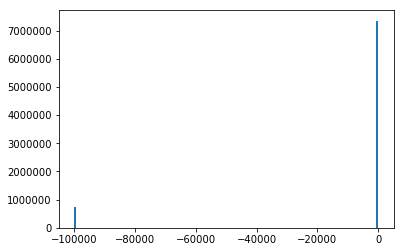

,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,Salinity,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),TrackNumber,Water Surface Elevation,hTime,oceanic depth,sTime
0,0.3105,-4,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,34.3,10.7,6.652769,111.0,0,0,100047,-0.22,0.258611,-4.0,931.0
1,0.3043,-11,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,34.3,10.7,9.012747,109.5,931,931,100047,-0.22,0.358333,-11.0,1290.0
2,0.3059,-16,8.779740,0.06,41.043652,1.279553,0.04,NaN,10.2,34.3,10.7,10.337037,117.4,2221,2221,100047,-0.23,0.458611,-16.0,1651.0
3,0.3674,-46,0.000000,0.08,40.998603,1.365502,0.07,NaN,10.5,34.3,10.6,0.000000,123.8,3872,3872,100047,-0.24,0.000278,-46.0,1.0
4,0.3674,-46,0.000095,0.08,40.998603,1.365502,0.07,NaN,10.5,34.3,10.6,0.046135,123.8,3873,3873,100047,-0.24,0.001111,-46.0,4.0


In [7]:
if 0 :
    trackAll.Latitude.sort_values().round().unique()
    trackAll.Longitude.sort_values().round().unique()
    trackAll.SOG.sort_values().round().unique()
    trackAll.Speed.sort_values().round().unique()
    trackAll.hTime.sort_values().round().unique()
    trackAll.hTime.min(),trackAll.hTime.max()
    trackAll.Depth.sort_values().round().unique()
    #-------------------------------
    plt.hist(trackAll.SOG[(trackAll.SOG>0) & (trackAll.SOG<30)],bins=50); plt.show()
    plt.hist(trackAll.Speed[(trackAll.Speed>0) & (trackAll.Speed<30)],bins=50); plt.show()
    temp = trackAll[(trackAll.Speed>0) & (trackAll.Speed<20) & (trackAll.SOG>0) & (trackAll.SOG<20)]
    plt.hist(temp.SOG-temp.Speed,bins=100); plt.show()
    #-------------------------------
    len(trackAll.Speed[(trackAll.Speed<0) | (trackAll.Speed>40)]), len(trackAll.SOG[(trackAll.SOG<0) | (trackAll.SOG>40)])
    
    print(len(trackAll.Depth[trackAll.Depth<-1000]),len(trackAll.Depth[trackAll.Depth>100]))
    plt.hist(trackAll.Depth[trackAll.Depth>0],bins=150); plt.show()
    trackAll.TrackNumber[trackAll.Depth<0].unique().shape
    
    plt.hist(trackAll.Distance[trackAll.Distance<10],bins=150); plt.show()
    
    plt.hist(trackAll.Salinity[trackAll.Salinity>0],bins=150); plt.show()

plt.hist(trackAll['Sea Temperature'],bins=150); plt.show()
trackAll.head()

In [8]:
##train_list.head()
trainIndex=train_list.copy()
##trainIndex.head()
trainIndex['y'] = -1
for ii in range(len(trainIndex)) : 
    trainIndex.y[ii] = y_class.index(trainIndex.typing[ii])
    
trainIndex=trainIndex.set_index('trackfile')
trainIndex.head()

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,typing,y
trackfile,,
100047,trawler,0
100070,longliner,1
100080,seiner,2
100093,other,3
100144,trawler,0


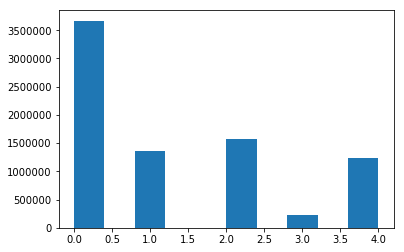

,TrackNumber,Chlorophyll Concentration,Depth,Distance,Eastward Water Velocity,Latitude,Longitude,Northward Water Velocity,Oceanic Depth,SOG,...,Sea Temperature,Speed,Thermocline Depth,Time,Time(seconds),Water Surface Elevation,hTime,oceanic depth,sTime,y
0,100047,0.3105,-4,3.186329,0.06,41.101078,1.235355,0.01,NaN,7.4,...,10.7,6.652769,111.0,0,0,-0.22,0.258611,-4.0,931.0,0
1,100047,0.3043,-11,5.981159,0.06,41.074507,1.221120,0.02,NaN,5.1,...,10.7,9.012747,109.5,931,931,-0.22,0.358333,-11.0,1290.0,0
2,100047,0.3059,-16,8.779740,0.06,41.043652,1.279553,0.04,NaN,10.2,...,10.7,10.337037,117.4,2221,2221,-0.23,0.458611,-16.0,1651.0,0
3,100047,0.3674,-46,0.000000,0.08,40.998603,1.365502,0.07,NaN,10.5,...,10.6,0.000000,123.8,3872,3872,-0.24,0.000278,-46.0,1.0,0
4,100047,0.3674,-46,0.000095,0.08,40.998603,1.365502,0.07,NaN,10.5,...,10.6,0.046135,123.8,3873,3873,-0.24,0.001111,-46.0,4.0,0


In [9]:
train = trackAll.set_index('TrackNumber')
train.head()
train['y'] = trainIndex.y
train = train.reset_index()
plt.hist(train.y); plt.show()
train.head()

In [10]:
import xgboost as xgb

/home/boba/anaconda2/envs/tensorflow-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [64]:
train_x = train.drop(['y','TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
train_y = train.y.values  #[:1000000]

mtrain = xgb.DMatrix(train_x,label=train_y)

In [65]:
train_y.shape, train_x.shape, train_x.columns, train_y.max()

((8080623,),
 (8080623, 17),
 Index([u'Chlorophyll Concentration', u'Depth', u'Distance',
        u'Eastward Water Velocity', u'Latitude', u'Longitude',
        u'Northward Water Velocity', u'Oceanic Depth', u'SOG', u'Salinity',
        u'Sea Temperature', u'Speed', u'Thermocline Depth',
        u'Water Surface Elevation', u'hTime', u'oceanic depth', u'sTime'],
       dtype='object'),
 4)

In [71]:
##import sklearn as sk
##from sklearn.model_selection import cross_val_score

In [109]:
##cross_val_score(estimator=xgb.XGBClassifier(), X=train_x, y=train_y, cv=5, scoring='accuracy')

array([ 0.74773878,  0.74648627,  0.789445  ,  0.79450295,  0.41711417])

In [30]:
parms = {'reg':'logistic'}
parms = {'multi':'softmax','num_class':5,'metrics':'mlogloss'}
##parms = {'reg':'logistic'}
##parms = {'reg':'linear','metrics':'auc'}

hist = xgb.cv(parms,mtrain,num_boost_round=300,nfold=5,early_stopping_rounds=4,verbose_eval=True,metrics='mlogloss')
#hist = xgb.train(parms,mtrain,num_boost_round=30,early_stopping_rounds=5)

[0]	train-mlogloss:1.18297+0.000609486	test-mlogloss:1.18298+0.000613475
[1]	train-mlogloss:0.96036+0.000381516	test-mlogloss:0.960418+0.000393776
[2]	train-mlogloss:0.813782+0.00117369	test-mlogloss:0.813876+0.00125842
[3]	train-mlogloss:0.710619+0.000813833	test-mlogloss:0.710766+0.00108814
[4]	train-mlogloss:0.63399+0.00104997	test-mlogloss:0.634145+0.0012031
[5]	train-mlogloss:0.574486+0.00186791	test-mlogloss:0.574658+0.00192195
[6]	train-mlogloss:0.528882+0.00179088	test-mlogloss:0.529057+0.00164409
[7]	train-mlogloss:0.494106+0.00196954	test-mlogloss:0.494293+0.00176724
[8]	train-mlogloss:0.466483+0.00181769	test-mlogloss:0.466671+0.0015286
[9]	train-mlogloss:0.443769+0.00166997	test-mlogloss:0.443964+0.00123989
[10]	train-mlogloss:0.424823+0.00063798	test-mlogloss:0.425027+0.000215014
[11]	train-mlogloss:0.40948+0.000545296	test-mlogloss:0.409682+0.000466275
[12]	train-mlogloss:0.395516+0.00138832	test-mlogloss:0.395704+0.00125923
[13]	train-mlogloss:0.38439+0.00145537	test-mlo

In [31]:
hist

,test-mlogloss-mean,test-mlogloss-std,train-mlogloss-mean,train-mlogloss-std
0,1.182977,0.000613,1.182968,0.000609
1,0.960418,0.000394,0.960360,0.000382
2,0.813876,0.001258,0.813782,0.001174
3,0.710766,0.001088,0.710619,0.000814
4,0.634145,0.001203,0.633990,0.001050
5,0.574658,0.001922,0.574486,0.001868
6,0.529057,0.001644,0.528882,0.001791
7,0.494293,0.001767,0.494106,0.001970
8,0.466671,0.001529,0.466483,0.001818
9,0.443964,0.001240,0.443769,0.001670


In [277]:
xgbmodel = xgb.train(parms,mtrain,num_boost_round=100,verbose_eval=True,xgb_model=xgbmodel) # 300+100

In [278]:
##xgbmodel.load_model('../Work/xgbModel.bst')

In [279]:
pred_y = xgbmodel.predict(mtrain); ##pred_y[-20:],pred_y.max()

In [282]:
((pred_y==train_y).sum()/float(len(pred_y)))

0.98223664190248694

In [283]:
xgbmodel.save_model('../Work/xgbModel.bst')

In [284]:
fimp  = xgbmodel.get_fscore();
ffimp = [[k,fimp[k]] for k in fimp.keys()]; 
ffimp.sort(key=lambda x: x[1],reverse=True)
tempsum = 0
for temp in ffimp : tempsum+=temp[1];
##print(tempsum)
for ii,temp in enumerate(ffimp) : 
    ffimp[ii][1] = float(ffimp[ii][1])/tempsum*100.0;
ffimp

[['Longitude', 12.512616584832777],
 ['Latitude', 11.6998429092896],
 ['SOG', 9.090771110487134],
 ['Oceanic Depth', 7.898551274559653],
 ['Eastward Water Velocity', 7.305097479718603],
 ['Water Surface Elevation', 6.902884549711241],
 ['Northward Water Velocity', 6.726062638972157],
 ['Sea Temperature', 6.5446873743084595],
 ['Chlorophyll Concentration', 6.166000106244924],
 ['Thermocline Depth', 6.040782873318105],
 ['Salinity', 5.03069719437509],
 ['Depth', 4.918381130901336],
 ['Speed', 2.6811665692754856],
 ['Distance', 2.482336781234111],
 ['hTime', 2.4072064414780185],
 ['oceanic depth', 1.5929149812933043]]

In [285]:
y_class, trainIndex['typing'][132759]

(['trawler', 'longliner', 'seiner', 'other', 'support'], 'seiner')

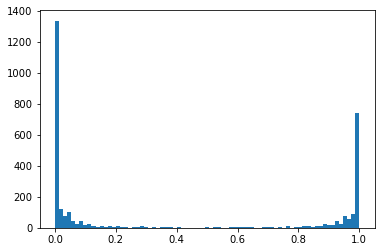

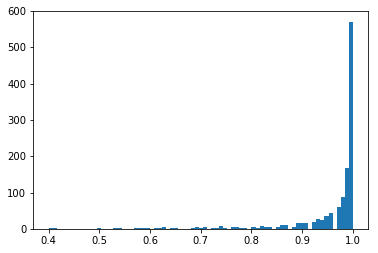

14

In [287]:
ppred = pd.DataFrame()
ppred['TrackNumber'] = train.TrackNumber
ppred['pred_y'] = pred_y
ppred['true_y'] = train.y


g0pred = ppred.groupby(['TrackNumber','pred_y']).agg(['count'])
g1pred = ppred.groupby(['TrackNumber']).agg(['count']); g1pred
g0pred['pr'] = np.round(g0pred.true_y/g1pred.true_y,2)
g2pred = g0pred.reset_index()
g2pred = g2pred.pr.groupby(g2pred.TrackNumber).max()
plt.hist(g0pred.pr,bins=75); plt.show()
plt.hist(g2pred,bins=75); plt.show()
#g0pred
g2pred.head()
len(g2pred[g2pred<0.60])

In [288]:
# Готовим решение по test

In [207]:
for ii,ffile in enumerate((test_list['trackfile'].values.tolist())): # [:10]) :
    xx = pd.read_csv(os.path.join('../Data/VesselTracks',str(ffile)+'.csv'))
    xx['Time']  = xx[[1]]
    xx['sTime'] = np.abs(xx.Time.diff(-1)).fillna(0.0)
    xx['hTime'] = xx.sTime/3600.0
    xx['Depth'] = xx[[5]]
    
    havLa       = (0.5*(1.0-np.cos(-xx.Latitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    havLo       = (0.5*(1.0-np.cos(-xx.Longitude.diff(-1)/180.0*math.pi))).fillna(0.0)
    
    cosLa       = (np.cos(xx.Latitude/180.0*math.pi)).fillna(0.0)
    
    hav         = (havLa+cosLa*cosLa.shift(-1)*havLo).fillna(0.0)
    dist = (2*6371.0*np.arcsin(np.sqrt(hav))).fillna(0.0)
    
    xx['Distance'] = dist
    xx['Speed']    = (dist/1.852/xx.hTime).fillna(0.0)
    
    if (ii==0) : testAll = xx.copy()
    else : testAll = testAll.append(xx.copy())
        
    ##print(len(xx),len(testAll),testAll.shape)
    
    if 0 : 
        #print('havLa',xx.havLa.values.tolist()[:10])
        #print(xx.havLo.values.tolist()[:10])
        #print(xx.cosLa.values.tolist()[:10])
        #print(xx.cosLa.shift(-1).values.tolist()[:10])
        #print('temp',temp.values.tolist()[-10:])
        #print('dist0',dist0.values.tolist()[-10:])
        print('dist',dist.values.tolist()[:20])
        #print('speed',xx.Speed.values.tolist()[:20])
        #print('SOG',xx.SOG.values.tolist()[-10:])
        print('sTime',xx.sTime.values.tolist()[:20])
        print('hTime',xx.hTime.values.tolist()[:20])
        print(zip(xx.Speed,xx.SOG)[:20])
    
print(testAll.shape)

(6586899, 20)


In [208]:
#testAll.to_csv('../Data/testingAll.csv',index=False)
testAll = pd.read_csv('../Data/testingAll.csv')

In [289]:
!ls -la ../Result
!ls -la ../Data
testAll.shape

total 81
drwxrwxrwx 1 boba boba   408 сен  1 17:01 .
drwxrwxrwx 1 boba boba  4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba 74416 сен  1 16:24 bobaFish-888703.csv
-rwxrwxrwx 1 boba boba   413 сен  1 16:53 FishingForFishermen2.java
drwxrwxrwx 1 boba boba     0 сен  1 16:36 .ipynb_checkpoints
total 2118448
drwxrwxrwx 1 boba boba       4096 сен  1 15:28 .
drwxrwxrwx 1 boba boba       4096 сен  1 16:12 ..
-rwxrwxrwx 1 boba boba  973453918 сен  1 15:29 testingAll.csv
-rwxrwxrwx 1 boba boba       8477 авг 25 23:42 testing.txt
-rwxrwxrwx 1 boba boba 1195264916 сен  1 00:12 trainingAll.csv
-rwxrwxrwx 1 boba boba      18151 авг 25 23:40 training.txt
drwxrwxrwx 1 boba boba     528384 авг 26 00:37 VesselTracks


(6586899, 20)

In [290]:
test_x = testAll.drop(['TrackNumber','Time','Time(seconds)'],axis=1)  #[:1000000]
mtest  = xgb.DMatrix(test_x)
test_x.shape

(6586899, 17)

In [291]:
test_y = xgbmodel.predict(mtest); ##pred_y[-20:],pred_y.max()

In [325]:
del g0pred,g1pred,g2pred,g3pred,g4pred,

   TrackNumber  pred_y
0       100015       1
1       100015       1
2       100015       1
3       100015       1
4       100015       2
('Common result \n',    TrackNumber  pred_y      pr
0       100015       0  0.0314
1       100015       1  0.8306
2       100015       2  0.1380
3       100045       0  0.9998
4       100045       2  0.0002)
Only result pred = 1.0 
   TrackNumber  pred_y   pr
0       100015       1  1.0
1       100045       0  1.0
2       100060       1  1.0
3       100112       0  1.0
4       100131       0  1.0


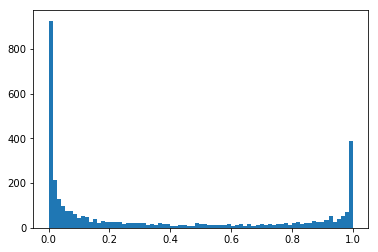

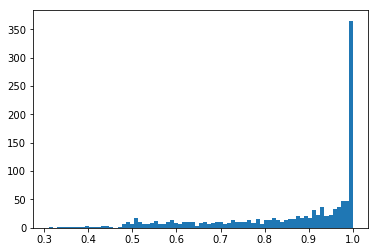

153


In [367]:
# Распределение результата test
ppred = pd.DataFrame()
ppred['TrackNumber'] = testAll.TrackNumber
ppred['pred_y'] = np.array(test_y,dtype=np.uint8)
print(ppred.head())

tySize = ppred.groupby(['TrackNumber','pred_y']).size();
tSize  = ppred.groupby(['TrackNumber']).size();

g0pred = pd.DataFrame(np.round(tySize/tSize,4)).reset_index()   # common result table [Track#, pred#, prob]
g0pred.columns=['TrackNumber','pred_y','pr']

print('Common result \n',g0pred.head())

ggmax, g4pred = [], g0pred.groupby('TrackNumber')

for tt in g0pred.TrackNumber.unique().tolist() :
    aa = g4pred.get_group(tt)
    ggmax.append(aa.pred_y[aa.pr.argmax()])

##print(len(ggmax),ggmax[:40])

g1pred = pd.DataFrame(g0pred.TrackNumber.unique())   # table only one max result for Track# [Track#, pred#, prob]
g1pred['pred_y'] = np.array(ggmax)
g1pred['pr']     = 1.0
g1pred.columns=['TrackNumber','pred_y','pr']

print 'Only result pred = 1.0 \n',g1pred.head()

g3pred = g0pred.pr.groupby(g0pred.TrackNumber).max()            # max pr for each Track#

plt.hist(g0pred.pr,bins=75); plt.show()
plt.hist(g3pred,bins=75); plt.show()

print len(g3pred[g3pred<0.60])

In [374]:
g0pred.head()
test_r = g0pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head(15))
#test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

    TrackNumber FishingType      pr
0        100015     trawler  0.0314
1        100015   longliner  0.8306
2        100015      seiner  0.1380
3        100045     trawler  0.9998
4        100045      seiner  0.0002
5        100060     trawler  0.0510
6        100060   longliner  0.7303
7        100060      seiner  0.2182
8        100060     support  0.0005
9        100112     trawler  1.0000
10       100131     trawler  0.9607
11       100131   longliner  0.0027
12       100131       other  0.0366
13       100150   longliner  0.9354
14       100150      seiner  0.0604


In [373]:
# Почему-то дает провал на 511650.89 с 890501, хотя не должна?
# Only max predictions pr<-1.0
g1pred.head()
test_r = g1pred.copy()
##print(test_r.pred_y.values.tolist())
test_r['FishingType'] = np.array([y_class[x] for x in test_r.pred_y.values.tolist()])
print(test_r[['TrackNumber','FishingType','pr']].head())
##test_r[['TrackNumber','FishingType','pr']].to_csv('../Result/bobaFish.csv',index=False,header=False)

   TrackNumber FishingType   pr
0       100015   longliner  1.0
1       100045     trawler  1.0
2       100060   longliner  1.0
3       100112     trawler  1.0
4       100131     trawler  1.0
